In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import multiprocessing
from snmfem.updates import dichotomy_simplex
import tqdm

In [ ]:
k = 5
p = 6400
span = np.logspace(-8,8,num=17)
iter = 100
TIMEOUT = 5

In [ ]:
for i in tqdm.tqdm(range(iter)) : 
    scale_num = np.random.choice(span,size=(k,p))
    num = scale_num * np.random.rand(k,p)
    scale_denum = np.random.choice(span,size=(k,p))
    denum = scale_denum * np.random.rand(k,p)
    dichotomy_simplex(num, denum)
    # process = multiprocessing.Process(target=dichotomy_simplex, name="fonction de ses morts", args=(num,denum))
    # process.start()
    # process.join(TIMEOUT)
    # if process.is_alive() :
    #     print('function terminated')
    #     N, D = num, denum
    #     process.terminate()
    #     process.join()
    #     break

# Tentative de faire un plot interactif des SpIm

In [ ]:
import hyperspy.api as hs 
import numpy as np
import snmfem.conf as conf
from pathlib import Path
import json

data_json = conf.SCRIPT_CONFIG_PATH / Path("dataset_EDXS_small.json")
with open(data_json,"r") as f :
    data_dict = json.load(f)

num_list = [0]
data_folder = conf.DATASETS_PATH / Path(data_dict["data_folder"])
samples = [data_folder / Path("sample_{}.npz".format(i)) for i in num_list ]

def load_data(sample) : 
    data = np.load(sample)
    X = data["X"]
    nx, ny, ns = X.shape
    Xflat = X.transpose([2,0,1]).reshape(ns, nx*ny)
    densities = data["densities"]
    phases = data["phases"]
    true_spectra_flat = np.expand_dims(densities, axis=1) * phases * data["N"]
    true_maps = data["weights"]
    k = true_maps.shape[2]
    true_maps_flat = true_maps.transpose([2,0,1]).reshape(k,nx*ny)
    G = data["G"]
    return Xflat, true_spectra_flat, true_maps_flat, G



In [ ]:
nx,ny = data_dict["weights_parameters"]["shape_2D"]
e_size = data_dict["model_parameters"]["e_size"]
X = load_data(samples[0])[0].T.reshape(nx,ny,e_size)
S = hs.signals.Signal1D(X)

In [ ]:
roi=hs.roi.RectangularROI(3,3,18,20)
S.plot(navigator="auto")
spim_ROI=roi.interactive(S)
    
sum_ROI=hs.interactive(spim_ROI.sum,
               event=spim_ROI.axes_manager.events.any_axis_changed,
               recompute_out_event=None)
sum_ROI.plot()

# Plot results

In [ ]:
from snmfem.conf import RESULTS_PATH, DATASETS_PATH
from snmfem.experiments import load_data
from pathlib import Path
import matplotlib.pyplot as plt
file = "best_lambda.npz"
dataset_path = DATASETS_PATH / Path("aspim037_N100_2ptcls_brstlg/sample_4.npz")
path = RESULTS_PATH / Path(file)
data = np.load(path)
X,true_spectra,true_maps,G,shape_2d = load_data(dataset_path)

In [ ]:
GP = data["GP"]
A = data["A"]
metrics = data["metrics"]
losses = data["losses"]

In [ ]:

fig,axes = plt.subplots(3,3,figsize= (50,50))
for i in range(3) : 
    axes[i,0].plot(true_spectra[i],'bo',label='truth',markersize = 5)
    axes[i,0].plot(GP[:,i],'r-',label='reconstructed',linewidth = 2)
    axes[i,1].imshow(A[i].reshape(shape_2d))
    axes[i,2].imshow(true_maps[i].reshape(shape_2d))
axes[0,0].legend(fontsize = 22)
axes[0,0].set_title("True vs reconstructed spectra",fontsize = 22)
axes[0,1].set_title("Reconstructed maps",fontsize = 22)
axes[0,2].set_title("True maps",fontsize = 22)
    

In [ ]:
fig, axes = plt.subplots(1,len(losses.dtype),figsize=(50,10))
for i,key in enumerate(losses.dtype.names) : 
    axes[i].plot(losses[key])
    axes[i].set_title(key,fontsize = 22)

In [ ]:
import snmfem.measures as m
import numpy as np 
import matplotlib.pyplot as plt 

a = 130*np.random.rand(3,256)
c = 23*np.random.rand(3,256)
ac = m.square_distance(a,c)
b = m.square_distance(a,np.zeros_like(a))
x = ac/b

In [ ]:
plt.imshow(ac)
plt.colorbar()

In [ ]:
plt.imshow(b)
plt.colorbar()

In [ ]:
plt.imshow(x)
plt.colorbar()

In [ ]:
for i in range(b.shape[0])  : 
    b[i,i] = 1

# Plots for PICO poster

In [ ]:
from snmfem.models import edxs
import numpy as np
from snmfem.models import EDXS_function as f
import matplotlib.pyplot as plt 
import hyperspy.api as hs
from scipy.optimize import curve_fit

file = "1135 EDS-HAADF.emd"
s1, haadf, spim = hs.load(file)
offset = spim.axes_manager[2].offset
size = spim.axes_manager[2].size
scale = spim.axes_manager[2].scale
max = offset + scale * size

x = np.linspace(offset,max,num= size)
spectrum = np.average(spim.data,axis= (0,1))
db = "default_xrays.json"
mod = edxs.EDXS(offset,size,scale,{},db_name = db)
mod.generate_g_matr([79])

In [ ]:
x1 = x[2230:2280]
x2 = x[2920:3000]
xdata = np.concatenate((x1,x2))
y1 = spectrum[2230:2280]
y2 = spectrum[2920:3000]
ydata = np.concatenate((y1,y2))

def droite (x,a,b) : 
    return a*x + b

popt, pcov = curve_fit(droite, xdata, ydata)

bkgdL = droite(x,*popt)

In [ ]:
x1 = x[350:400]
x2 = x[700:800]
xdata = np.concatenate((x1,x2))
y1 = spectrum[350:400]
y2 = spectrum[700:800]
ydata = np.concatenate((y1,y2))

def droite (x,a,b) : 
    return a*x + b

popt, pcov = curve_fit(droite, xdata, ydata)

bkgdM = droite(x,*popt)

In [ ]:
markers = ["o-",".-","--",">-","^-","<-","s-","p-","X-"]
for i, line in enumerate(mod.G.T) : 
    plt.plot(line,markers[i],markevery= 10,label=str(i))
    plt.plot(spectrum)
    plt.xlim(200,1000)
    plt.ylim(0,0.02)

plt.legend()

In [ ]:
plt.plot(x,spectrum,label="exp")
plt.plot(x,bkgdM + mod.G.T[0]*3.3e19,label="theo")
plt.ylim(0,0.08)
plt.xlim(0,5)
plt.legend()
plt.title("Gold M Lines")

In [ ]:
plt.plot(x,spectrum,label="exp")
plt.plot(x,bkgdL + mod.G.T[0]*3.3e19,label="theo")
plt.ylim(0,0.025)
plt.xlim(9,15)
plt.legend()
plt.title("Gold L Lines")

In [ ]:
plt.plot(x,mod.G)

In [ ]:
np.savetxt("G_Zn.txt",mod.G.T)

In [ ]:
dict = {"c0" : 4.8935e-05, 
                                          "c1" : 1464.19810,
                                          "c2" : 0.04216872,
                                          "b0" : 0.15910789,
                                          "b1" : -0.00773158,
                                          "b2" : 8.7417e-04,
                                          "k" : 3}

s = hs.load("/mnt/c/Users/teurtrie/Travail/SNMF_EDXS/snmfem/Data/average_spectrum_1537.hspy")
s2 = s.isig[0.5:10.0]

In [ ]:
E = np.linspace(0.2,20.0,num = 2000)

plt.plot(E,b)
plt.plot(E,d)
plt.plot(E,a)
plt.plot(E,a*b*d)

In [ ]:
db = "default_xrays.json"
mod = edxs.EDXS(0.49765,1900,0.005,{},db_name = db)
mod.generate_g_matr([30])

x = np.linspace(0.49765,1900*0.005 + 0.49765,num = 1900)
b = f.bremsstrahlung(x,0.0053,-3.74e-5,3.55e-12)
abs = f.simple_abs_coeff(x)
d = f.detector(abs,3867,0.019)
a = f.self_abs(abs,0.0082)
plt.plot(x,s2.data,"ko-",markersize = 3,markevery = 20,label = "experimental")
plt.plot(x,a*b*d,"r",label = "model",linewidth = 2)
plt.plot(x,0.0035*mod.G.T[0] + a*b*d)
plt.ylim(-0.001,0.05)
plt.xlim(8,10)
plt.xlabel("Energy (keV)")
plt.yticks([])
plt.legend()
plt.ylabel("Intensity (arb. unit)")

In [ ]:
array = np.vstack([x,s2.data,b*a*d])

In [ ]:
np.savetxt("brem.txt",array)

In [ ]:
s = hs.load("/mnt/c/Users/teurtrie/Travail/SNMF_EDXS/snmfem/Data/71GPa_subsolidus.hspy")

In [ ]:
s.data = s.data.astype("float64")
s.decomposition(True,output_dimension = 3, algorithm = "NMF",max_iter = 1000)

In [ ]:
sc = s.get_decomposition_factors()

In [ ]:
y = sc.inav[1].data
x = np.linspace(s.axes_manager[2].offset,s.axes_manager[2].scale * s.axes_manager[2].size + s.axes_manager[2].offset, num = s.axes_manager[2].size)

In [ ]:
h = np.vstack((x,y))
np.savetxt("nmf_artefacts.txt",h)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
a = np.load("/mnt/c/Users/teurtrie/Travail/SNMF_EDXS/results/dump.npz")
m = a["A"][0,:]

In [ ]:
plt.imshow(m.reshape(80,80))

In [ ]:
for key in a.keys() :
    print(key)

In [ ]:
import json
table = {"table" : {"K" : 3,"X" : 4}}
cs = {"thres" : 10}
filename = "dummy.json"
with open(filename, "w") as f:
            json.dump(table, f, indent=4)
            json.dump(cs,f,indent=4)


# Test estimator

In [7]:
from sklearn.utils.estimator_checks import check_estimator
from snmfem.estimators import NMF, SmoothNMF
import numpy as np
from snmfem.datasets.generate_data import ArtificialSpim
from snmfem.models import EDXS
from snmfem.datasets.generate_weights import generate_weights
from snmfem.measures import trace_xtLx, KL
from snmfem.laplacian import create_laplacian_matrix
from snmfem.experiments import run_experiment
import matplotlib.pyplot as plt 
%matplotlib inline

def generate_one_sample():
    model_parameters  = {"params_dict" : {  "b0" : 0.15910789,
                                            "b1" : -0.00773158,
                                            "b2" : 8.7417e-04},
                            "db_name" : "default_xrays.json",
                            "e_offset" : 0.208,
                            "e_scale" : 0.01,
                            "e_size": 1980,
                            "width_slope" : 0.01,
                            "width_intercept" : 0.065,
                            "seed" : 1}


    g_parameters = {"thickness": 2e-05,
            "density": 3.5,
            "toa": 22,
            "elements_list" : [8,13,14,12,26,29,31,72,71,62,60,92,20],
            "brstlg" : 1}

    phases_parameters =  [
        {"thickness": 2e-05,
            "density": 3.5,
            "toa": 22,
            "atomic_fraction": True,
            "elements_dict":{"8": 1.0 , "12": 0.51  , "14": 0.61  , "13": 0.07  , "20": 0.04  , "62": 0.02  ,
                            "26": 0.028  , "60": 0.002  , "71": 0.003  , "72": 0.003  , "29": 0.02  }, 
            "scale" : 0.01},
        {"thickness": 2e-05,
            "density": 3.5,
            "toa": 22,
            "atomic_fraction": True,
            "elements_dict":{"8": 0.54  , "26": 0.15  , "12": 1.0  , "29": 0.038  ,
                            "92": 0.0052  , "60": 0.004  , "31": 0.03  , "71": 0.003  },
            "scale" : 0.01},   
            {"thickness": 2e-05,
            "density": 3.5,
            "toa": 22,
            "atomic_fraction": True,
            "elements_dict":{"8": 1.0  , "14": 0.12  , "13": 0.18  , "20": 0.47  ,
                            "62": 0.04  , "26": 0.004  , "60": 0.008  , "72": 0.004  , "29": 0.01  }, 
            "scale" : 0.01} 
        ]

    # Generate the phases
    model = EDXS(**model_parameters)
    model.generate_g_matr(**g_parameters)
    model.generate_phases(phases_parameters)
    phases = model.phases
    G = model.G

    seed = 0
    n_phases = 3
    weights_parameters = {"weight_type": "laplacian",
                            "shape_2D": [15, 15]}

    weights = generate_weights(**weights_parameters, n_phases=n_phases, seed=seed)

    # list of densities which will give different total number of events per spectra
    densities = np.array([1.0, 1.33, 1.25])

    spim = ArtificialSpim(phases, densities, weights, G=G)

    N = 50
    spim.generate_spim_stochastic(N)

    D = spim.phases.T
    A = spim.flatten_weights()
    P = np.abs(np.linalg.lstsq(G, D, rcond=None)[0])
    X = spim.flatten_gen_spim()

    w = spim.densities
    Xdot = spim.flatten_Xdot()
    return G, P, A, D, w, X, Xdot/N


def test_generate_one_sample():
    G, P, A, D, w, X, Xdot = generate_one_sample()
    np.testing.assert_allclose(G @ P , D, atol=1e-5)
    np.testing.assert_allclose(D @ np.diag(w) @ A , Xdot)
    np.testing.assert_allclose(G @ P @ np.diag(w) @ A , Xdot, atol=1e-5)

G, P, A, D, w, X, Xdot = generate_one_sample()

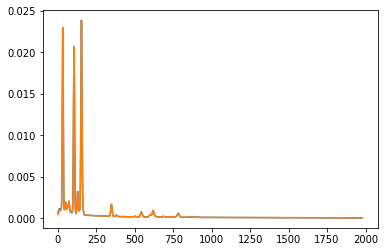

In [8]:
plt.plot((G@P).T[0])
plt.plot(D.T[0])



In [5]:
from snmfem.models.absorption_edxs import absorption_correction

elts = {"8": 1.0 , "12": 0.51  , "14": 0.61  , "13": 0.07  , "20": 0.04  , "62": 0.02  ,
                            "26": 0.028  , "60": 0.002  , "71": 0.003  , "72": 0.003  , "29": 0.02 }

elts2 = {"8": 0.09 , "12": 0.09  , "14": 0.09  , "13": 0.09  , "20": 0.09  , "62": 0.09  ,
                            "26": 0.09  , "60": 0.09  , "71": 0.09  , "72": 0.09  , "29": 0.09 }

x = np.linspace(0.208, 1980*0.01+0.208, num = 1980)
a = absorption_correction(x,thickness = 1e-5, toa = 22, density= 3.5,atomic_fraction=True, elements_dict = elts)
a2 = absorption_correction(x,thickness = 1e-5, toa = 22, density= 3.5,atomic_fraction=True, elements_dict = elts2)

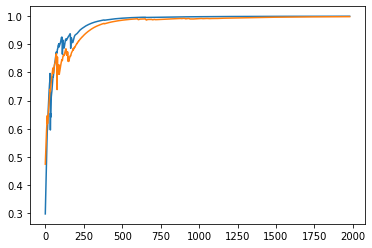

In [6]:
plt.plot(a)
plt.plot(a2)

In [ ]:
print(np.max((G@P).T[2] - D.T[2]))